# Sales prediction for Clinic

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import data and set date as index
clinic_df = pd.read_csv(r'C:\Users\Tuan Nguyen\Desktop\Clinic_Test\fake_clinic_data_extract_test.csv'\
                        , index_col = 'date', parse_dates = True, names = ['date', 'clinic', 'patient_id', 'practitioner_id'\
                        , 'duration', 'revenue'], header = 0).sort_index()

#Take a look of the first 5 rows
clinic_df.head()

,clinic,patient_id,practitioner_id,duration,revenue
date,,,,,
2021-06-28,clinic_2,42817,748,30,94.16
2021-06-28,clinic_2,42734,741,30,90.72
2021-06-28,clinic_2,42734,742,60,119.18
2021-06-28,clinic_2,42828,748,30,135.40
2021-06-28,clinic_2,42155,748,30,87.28


## Data cleaning

In [2]:
#Check data types of our data
clinic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4071 entries, 2021-06-28 to 2021-12-30
Data columns (total 5 columns):
clinic             4071 non-null object
patient_id         4071 non-null int64
practitioner_id    4071 non-null int64
duration           4071 non-null int64
revenue            3696 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 190.8+ KB


In [3]:
#Another way to make sure our columns are numerical
#We can create function to change data type
def change_numeric(df, *cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    return df.head()

change_numeric(clinic_df, "patient_id", "practitioner_id", "duration", "revenue")

,clinic,patient_id,practitioner_id,duration,revenue
date,,,,,
2021-06-28,clinic_2,42817,748,30,94.16
2021-06-28,clinic_2,42734,741,30,90.72
2021-06-28,clinic_2,42734,742,60,119.18
2021-06-28,clinic_2,42828,748,30,135.40
2021-06-28,clinic_2,42155,748,30,87.28


In [4]:
#Take a look of the statistical summary 
clinic_df.describe(include = 'all')

,clinic,patient_id,practitioner_id,duration,revenue
count,4071,4071.000000,4071.000000,4071.000000,3696.000000
unique,2,NaN,NaN,NaN,NaN
top,clinic_1,NaN,NaN,NaN,NaN
freq,2429,NaN,NaN,NaN,NaN
mean,NaN,50352.166789,766.627364,42.246377,160.864115
std,NaN,7371.897408,64.550564,28.539519,245.706333
min,NaN,42127.000000,741.000000,15.000000,33.540000
25%,NaN,44646.000000,742.000000,30.000000,72.160000
50%,NaN,47388.000000,755.000000,30.000000,104.470000
75%,NaN,53373.000000,756.000000,60.000000,161.630000


In [5]:
#Separating the rows with revenue is NaN
revenue_nan = clinic_df[clinic_df.revenue.isna()]

#See how many rows with missing revenues
print('Number of row with missing revenues: ', revenue_nan.shape[0])

revenue_nan.head()

Number of row with missing revenues:  375


,clinic,patient_id,practitioner_id,duration,revenue
date,,,,,
2021-06-29,clinic_2,42859,742,60,NaN
2021-07-07,clinic_2,42950,741,30,NaN
2021-07-07,clinic_2,42412,742,60,NaN
2021-07-08,clinic_1,43630,755,15,NaN
2021-07-12,clinic_1,43683,756,30,NaN


The reason for these rows with missing revenue is unknown. We can drop these rows or impute them with an appropriate values.
Since we have informations from other columns, we can match these rows with other rows which contain the same information.

In [6]:
#Try to match clinic_name, patient_id and practitioner_id to fill in the missing revenues
#By merging two dataframes, one has NaN and the other has no NaN

#Adding the date column because the index will be gone after the merge (unless we merge right on the index)

revenue_nan_merged = revenue_nan.assign(date = revenue_nan.index)\
                        .merge(clinic_df[clinic_df.revenue.notna()]\
                        , how = 'inner', left_on = ['clinic', 'patient_id'\
                        ,'practitioner_id', 'duration'], \
                        right_on = ['clinic', 'patient_id', 'practitioner_id',\
                                        'duration'], suffixes= ('_before','_after'))

print(revenue_nan_merged.shape)

print(revenue_nan_merged.isna().sum())

revenue_nan_merged.head()

(115, 7)
clinic               0
patient_id           0
practitioner_id      0
duration             0
revenue_before     115
date                 0
revenue_after        0
dtype: int64


,clinic,patient_id,practitioner_id,duration,revenue_before,date,revenue_after
0,clinic_2,42950,741,30,NaN,2021-07-07,102.39
1,clinic_1,43683,756,30,NaN,2021-07-12,39.37
2,clinic_1,43322,756,60,NaN,2021-07-22,123.18
3,clinic_1,43322,756,60,NaN,2021-07-22,52.58
4,clinic_1,44122,757,60,NaN,2021-07-26,149.47


After matching we now have 115 more rows with revenue values. But we still need to check for duplication. At first glance, we can see there is one duplication for patient_id 43322 on 2021-07-22.

In [7]:
#Examing the patient_id 43322 for the date 2021-07-22
check_dup = clinic_df.query('clinic == "clinic_1" & patient_id == 43322 & practitioner_id == 756 & duration == 60', inplace = False)

check_dup

,clinic,patient_id,practitioner_id,duration,revenue
date,,,,,
2021-07-08,clinic_1,43322,756,60,123.18
2021-07-13,clinic_1,43322,756,60,52.58
2021-07-22,clinic_1,43322,756,60,NaN


In [8]:
#We will drop the duplicates and only keep the last match (i.e. 52.58 in this example)
#We aslo make some adjustments for these new filled rows in order to merge to the main data later

revenue_adj = revenue_nan_merged.drop_duplicates(subset = ['clinic', 'patient_id', 'practitioner_id', 'duration', 'date'], \
                                   keep = 'last', inplace = False).set_index('date').drop(columns ='revenue_before')\
                                    .rename(columns = {'revenue_after':'revenue'}).sort_index()

revenue_adj.head()

,clinic,patient_id,practitioner_id,duration,revenue
date,,,,,
2021-07-07,clinic_2,42950,741,30,102.39
2021-07-12,clinic_1,43683,756,30,39.37
2021-07-22,clinic_1,43322,756,60,52.58
2021-07-26,clinic_1,44122,757,60,149.47
2021-07-26,clinic_1,44351,756,60,184.59


In [9]:
#Merging the revenue_adj dataframe with the main data

clinic_df_rev = pd.concat([clinic_df[clinic_df.revenue.notna()], revenue_adj]).sort_index()

In [10]:
clinic_df_rev.describe()

,patient_id,practitioner_id,duration,revenue
count,3763.000000,3763.000000,3763.000000,3763.00000
mean,50354.820888,767.809726,41.793782,159.87971
std,7401.338334,66.444790,29.070264,244.12968
min,42127.000000,741.000000,15.000000,33.54000
25%,44644.000000,742.000000,30.000000,72.16000
50%,47310.000000,756.000000,30.000000,103.50000
75%,53374.000000,756.000000,60.000000,160.17000
max,70307.000000,1030.000000,330.000000,5655.92000


From the statistical summary, we may question why 75% of daily revenue is equal or less than 160.17 but the maximum is 5655.
Is there some typo mistake?

In [11]:
#Check how many patients spend more than 1000 in one day
print('Number of patients spend more than 1000 in one day: ',clinic_df_rev.query('revenue >= 1000').shape[0])

#Check how many patients spend more than 1000 in one day with duration over 60 minutes
print('Number of patients spend more than 1000 and over 60 minutes in one day: ',\
      clinic_df_rev.query('revenue >= 1000 & duration > 60').shape[0])


Number of patients spend more than 1000 in one day:  34
Number of patients spend more than 1000 and over 60 minutes in one day:  14


The significant amounts may due to the type of treatment for some patients. Since only 14 patients who spend more than $1000 in one time treatment have the duration over 60 minutes.

In [12]:
clinic_df_rev['day_of_week'] = clinic_df_rev.index.day_name()

In [13]:
clinic_df_rev.head()

,clinic,patient_id,practitioner_id,duration,revenue,day_of_week
date,,,,,,
2021-06-28,clinic_2,42817,748,30,94.16,Monday
2021-06-28,clinic_2,42774,741,15,51.77,Monday
2021-06-28,clinic_2,42157,742,60,119.04,Monday
2021-06-28,clinic_2,42857,748,30,193.81,Monday
2021-06-28,clinic_2,42798,748,30,128.52,Monday


We will resample data using datetime index.

In [14]:
#Resampling data to have total revenue of business days

# When we resample by "D" or "B". There will be some new rows. In this case, with "B", 
# we will have new '2021-11-01' and '2021-12-24'.
# Since both is holiday, so they only contain 0. But these 0 are not considered as Null/NaN 
# (because when we check .isnull(), there is no null/NaN)
# therefore we will replace 0 as NaN and then dropna()

clinic_df_biz = clinic_df_rev.resample('B').sum().replace(0, np.nan).dropna()

#Check again
clinic_df_biz[clinic_df_biz.revenue == 0]

,patient_id,practitioner_id,duration,revenue
date,,,,


## Data Analyse

For the prediction we will use *ARIMA(p,d,q)* model. The followings are preparation steps for our model.

Text(0.5, 0, 'Date')

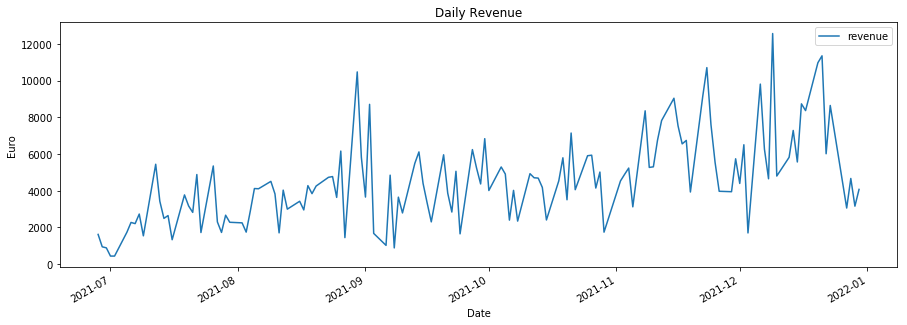

In [15]:
#Ploting to see if there is obvious trend or seasonal movement in data
clinic_df_biz.plot(y= 'revenue', figsize = (15,5), title ='Daily Revenue')
plt.ylabel('Euro')
plt.xlabel('Date')

From the simple plot there is is no obvious sign for trend and seasonal, we will use *seasonal_decompose* function to check.

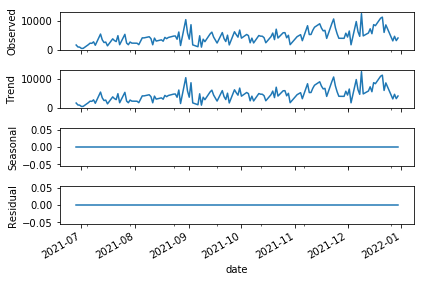

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_season = seasonal_decompose(clinic_df_biz["revenue"], model ='additive', freq = 1)
result_season.plot()
plt.show()

There is no seasonal and the trend seems to be up in the long run. Next we check if the data is stationary using **Adfuller** test. Stationary is an important requirement for using ARIMA model.

In [17]:
from statsmodels.tsa.stattools import adfuller

result_adf = adfuller(clinic_df_biz.revenue)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')

for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.953075
p-value: 0.307519
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580


Because ADF Statistic is higher than Critical Values, we cannot reject the null hypothesis that our data is non-stationary, so we need to make adjustment for it to be stationary before applying time series model like **ARIMA(p,d,q)**.


ADF Statistic: -6.309222
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580


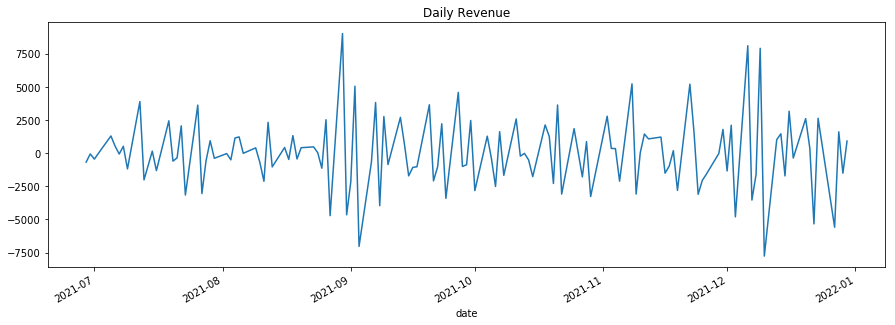

In [18]:
#We use differencing to detrend our data
clinic_1diff = clinic_df_biz.revenue.diff().dropna()
result_diff_adf = adfuller(clinic_1diff)

print('ADF Statistic: %f' % result_diff_adf[0])
print('p-value: %f' % result_diff_adf[1])
print('Critical Values:')

for key, value in result_diff_adf[4].items():
    print('\t%s: %.3f' % (key, value))

clinic_1diff.plot(y= 'revenue', figsize = (15,5), title ='Daily Revenue')
plt.show()

After using first different (i.e. *d =1* for ARIMA model), the ADF Statistic is now lower than Critical Values which mean first differenced data is stationary. The line plot also confirms that the trend is eliminated. Next we plot its histogram and KDE to double check.

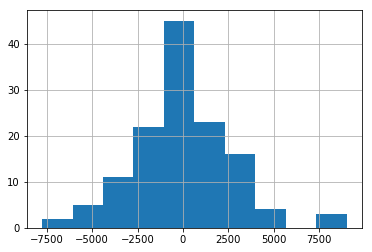

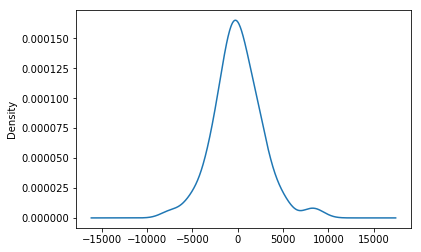

In [19]:
clinic_1diff.hist()
plt.show()
clinic_1diff.plot(kind ='kde')
plt.show()

First differenced data *clinic_1diff* seems to have a Gaussian distribution with mean is zero which is what we need from a stationary data.

In [20]:
#Since the data is a bit short (July 2021 - January 2022)
#We keep the last month January as a test set for model validation

train = clinic_df_biz.revenue[:'2021-11-30']
test = clinic_df_biz.revenue['2021-12-01':]

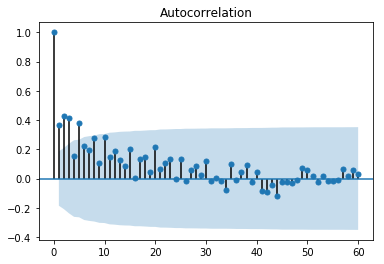

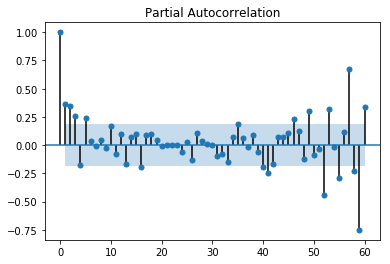

In [21]:
# We now using autocorrelation plot to find the lag order for AutoRegressive and MovingAverage parts of ARIMA 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(train, lags = 60)
plt.show()

plot_pacf(train, lags = 60)
plt.show()

From ACF plot, the first 5 lags seems to have significant correlation. While PACF suggest a lag order of 3 but in experiments there will be mathmetical problems with library. Therefore we will use *d=0*. As of now we have a good starting point for ARIMA(p,d,q) at ***order (5,1,0)***.

In [22]:
#Using ARIMA model for prediction
from statsmodels.tsa.arima_model import ARIMA
arima_model = ARIMA([x for x in train], order =(5, 1, 0))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  110
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -974.704
Method:                       css-mle   S.D. of innovations           1696.636
Date:                Sat, 18 Jun 2022   AIC                           1963.409
Time:                        15:26:45   BIC                           1982.312
Sample:                             1   HQIC                          1971.076
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6492     53.835      0.774      0.441     -63.866     147.164
ar.L1.D.y     -0.7602      0.094     -8.080      0.000      -0.945      -0.576
ar.L2.D.y     -0.4441      0.112     -3.957      0.0

We use the method called *walk-forward* for validating our model.

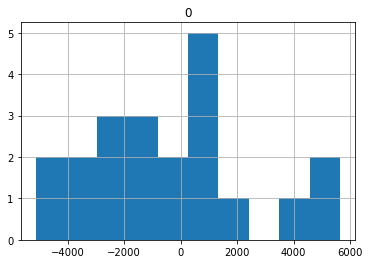

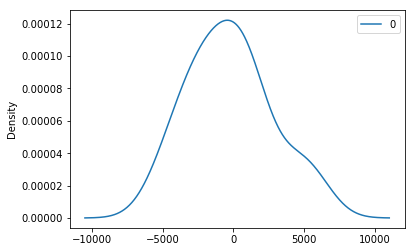

In [23]:
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order = (5,1,0))
    model_fit = model.fit(disp = 0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    #Adding observed values from Test set to extend our database which help improve prediction accuracy. 
    obs = test[i]
    history.append(obs)

#Residual errors from our prediction will be test to make sure that our model captured all variation
#Ideally residuals will be white noise which means they follow Gaussian distribution with mean is zero 
residuals = [test[i] - predictions[i] for i in range(len(test))]    
residuals = pd.DataFrame(residuals)

residuals.hist()
plt.show()
residuals.plot(kind="kde")
plt.show()

The distribution of residuals has a bell shape of Gaussian distribution, but it means is not yet zero and it is skewed to the left. We wil aslo check if there is autocorrelation inside the residuals.

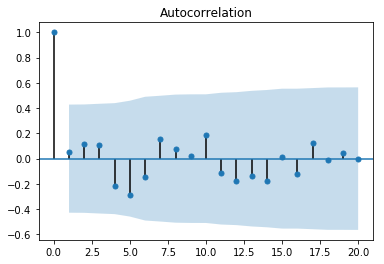

In [24]:
plot_acf(residuals, alpha =0.05)
plt.show()

It seems like our model has captured the autocorrelation in our data.

In [25]:
#Check model accuracy using Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt 

rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 2876.912


In [26]:
#Transform prediction values into a dataframe with date index corresponding to our test set
predictions_df = pd.DataFrame(predictions, index = test.index, columns =['Prediction values'])

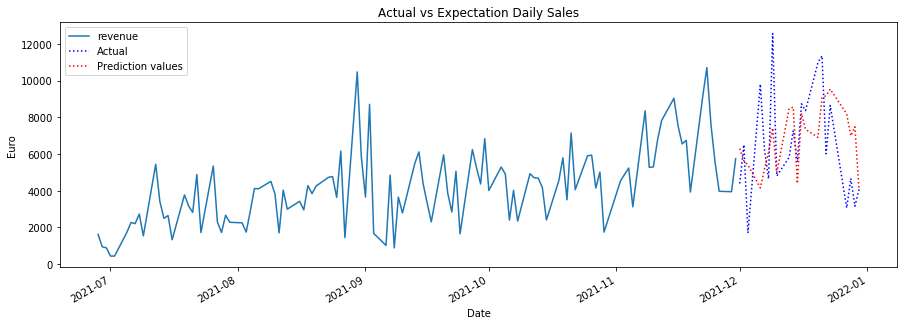

In [34]:
#PLotting our predictions and the actual daily sales
plt.figure(figsize = (15,5))
ax = train.plot(title = 'Actual vs Expectation Daily Sales')
test.plot(ax = ax, style ='b:', label = 'Actual')
predictions_df.plot(ax =ax, style ='r:', label = 'Expectation')
plt.xlabel('Date')
plt.ylabel('Euro')
plt.legend()
plt.show()

From the above graph we can see that there is a lag in our prediction. These difference may caused by the volatility of the daily sales since it is still in the pandemic period and there is some exceptional high treatment costs for some patients. Regarding the improvement, we can try to difference time frame like monthly instead of daily or we can use different models or apply machine learning to our prediction process.